# Курсовой проект

## Описание проекта
**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

## Обзор данных<a class="anchor" id="course_project_review"></a>
**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - кредитный рейтинг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [487]:
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings

from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV

%matplotlib inline
warnings.filterwarnings('ignore')

**Пути к директориям и файлам**

In [488]:
TRAIN_DATASET_PATH = './kaggle/train.csv'
TEST_DATASET_PATH = './kaggle/test.csv'

In [489]:
tfull = pd.read_csv(TRAIN_DATASET_PATH)
train_full = tfull.copy()

In [490]:
# N = 5000
# #train
# train_full = tfull.iloc[:N,:].copy()
# #test
# test_full = tfull.iloc[N:,:-1].copy()
# #key ans
# test_full_ans = tfull.iloc[N:,-1].copy()

# display(train_full.shape)
# display(test_full.shape)

In [491]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = train_full.columns.drop(TARGET_NAME).tolist()
# TEST_BASE_FEATURE_NAMES = test_full.columns.tolist()
NEW_FEATURE_NAMES = train_full.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

In [492]:
train_full.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,7500.0,3.749500e+03,2.165208e+03,0.0,1874.75,3749.5,5624.25,7.499000e+03
Annual Income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.00,1168386.0,1640137.00,1.014934e+07
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.00,0.0,0.00,7.000000e+00
Number of Open Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.00,10.0,14.00,4.300000e+01
Years of Credit History,7500.0,1.831747e+01,7.041946e+00,4.0,13.50,17.0,21.80,5.770000e+01
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.50,478159.0,793501.50,1.304726e+09
Number of Credit Problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.00,0.0,0.00,7.000000e+00
Months since last delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.00,32.0,50.00,1.180000e+02
Bankruptcies,7486.0,1.171520e-01,3.471917e-01,0.0,0.00,0.0,0.00,4.000000e+00
Current Loan Amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.00,309573.0,519882.00,1.000000e+08


In [493]:
train_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id                            7500 non-null   int64  
 1   Home Ownership                7500 non-null   object 
 2   Annual Income                 5943 non-null   float64
 3   Years in current job          7129 non-null   object 
 4   Tax Liens                     7500 non-null   float64
 5   Number of Open Accounts       7500 non-null   float64
 6   Years of Credit History       7500 non-null   float64
 7   Maximum Open Credit           7500 non-null   float64
 8   Number of Credit Problems     7500 non-null   float64
 9   Months since last delinquent  3419 non-null   float64
 10  Bankruptcies                  7486 non-null   float64
 11  Purpose                       7500 non-null   object 
 12  Term                          7500 non-null   object 
 13  Cur

### Проверка значений базовых признаков
Функция _check_feature_values(df)_ выводит информацию о типе данных признака, количество пропусков, уникальные значения, определяет возможность преобразования float &#8594; int

In [494]:
def check_feature_values(df):
    FEATURE_NAMES = BASE_FEATURE_NAMES
    dataset_size = df.index.size
    features_to_int = []
    features_with_nans = {}
    features_binary = []
    features_dummies = []
    for feature in FEATURE_NAMES:
        non_nan_count = df[feature].count()
        unique_values = df[feature].unique()
        if len(unique_values) > 20:
            unique_values_str = str(unique_values[:5]) + ' ... ' + str(unique_values[len(unique_values) - 5:])
        else:
            unique_values_str = str(unique_values)
        print(f"\033[1m{feature}\033[0m")
        print(f"\t\033[1mUnique values:\033[0m\n\t{unique_values_str}")
        print(f"\t\033[1mFeature not NaN size:\033[0m {non_nan_count}")
        print(f"\t\033[1mType of values:\033[0m {df.dtypes[feature]}")
        if non_nan_count == dataset_size:
            print(f"\033[95mПропусков нет\033[0m")
        elif non_nan_count / dataset_size > 0.9:
            print(f"\033[95mНемного пропусков\033[0m {dataset_size - non_nan_count}")
        else:
            print(f"\033[95mМного пропусков\033[0m {dataset_size - non_nan_count}")

        # Проверка float-значений на целые.
        # Если тип float, но при этом дробные части всех элементов равны 0, можно преобразовать в int
        int_flag = True

        if df.dtypes[feature] == np.float64 and dataset_size == non_nan_count:
            for i in df[feature]:
                try:      
                    if not pd.isna(i) and i != int(i):
                        int_flag = False
                        break
                except:
                    int_flag = False
        else:
            int_flag = False
        if int_flag:
            print(f"\033[92mПреобразовать в INT\033[0m")
            features_to_int.append(feature)

        # Формирование словаря признаков с пропусками
        if dataset_size != non_nan_count:
            features_with_nans[feature] = dataset_size - non_nan_count

        # Если признак состоит из 2 значений типа object, можно заменить их на 0 и 1
        if df.dtypes[feature] == np.object and len(unique_values) == 2:
            features_binary.append(feature)
            print(f"\033[94mПреобразовать значения категориального признака {feature} в 0 и 1\033[0m")
        if df.dtypes[feature] == np.object and len(unique_values) > 2:
            features_dummies.append(feature)
        print('*' * 50)
    return features_with_nans, features_to_int, features_binary, features_dummies

In [495]:
# Тренировочный датасет
train_pass_features, train_features_to_int, train_features_binary, train_features_dummies = check_feature_values(train_full)

Id
	Unique values:
	[0 1 2 3 4] ... [7495 7496 7497 7498 7499]
	Feature not NaN size: 7500
	Type of values: int64
Пропусков нет
**************************************************
Home Ownership
	Unique values:
	['Own Home' 'Home Mortgage' 'Rent' 'Have Mortgage']
	Feature not NaN size: 7500
	Type of values: object
Пропусков нет
**************************************************
Annual Income
	Unique values:
	[ 482087. 1025487.  751412.  805068.  776264.] ... [5327372. 1368000. 2833185. 1257610.  402192.]
	Feature not NaN size: 5943
	Type of values: float64
Много пропусков 1557
**************************************************
Years in current job
	Unique values:
	[nan '10+ years' '8 years' '6 years' '7 years' '5 years' '1 year'
 '< 1 year' '4 years' '3 years' '2 years' '9 years']
	Feature not NaN size: 7129
	Type of values: object
Немного пропусков 371
**************************************************
Tax Liens
	Unique values:
	[0. 3. 1. 2. 4. 6. 5. 7.]
	Feature not NaN size: 7500
	Ty

### Обзор целевого признака

In [496]:
train_full[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Данные разбалансированы

### Удаление строк с пропусками

In [497]:
# train_full.columns

In [498]:
# train_full.dropna(inplace=True)

In [499]:
# train_full.info()

## Анализ и обработка признаков

In [500]:
def CHi_check(df, col, list_samp, sample_num):
#     print(f"col: {col}")
    p = 0
    df_isin_samp = df[col].isin(list_samp)
    numb_sample = np.sum(df_isin_samp)
#     print(numb_sample)
    if numb_sample > sample_num:
#         numb_sample = 500
#         if numb_sample > 50:
        col_and_target_s = df.loc[df_isin_samp, ['Id', col, TARGET_NAME]].sample(sample_num)
#         print(col_and_target_s) 
        table = col_and_target_s.pivot_table(values='Id', index=col, columns=TARGET_NAME, aggfunc='count')
#         print(table)

        chi2, p, dof, expected = chi2_contingency(table, correction=False)
        return p

In [501]:
alpha = 0.05
def check_feature_chi(df, feature, sample_num):
    f_uniq = df[feature].unique()
    #print(feature,': ',f_uniq)
    for i in f_uniq:
        for j in f_uniq:
            if i != j:
                try:
                    p = CHi_check(df, feature, [i,j], sample_num)
                    if p > alpha:
                        print(f"{feature}: [{i}, {j}] - {p}")
                except:
                    pass

In [502]:
# countplot по отношению к целевому признаку
def countplot_by_target(df, feature, rotation=0):
    plt.figure(figsize=(14, 6))
    chart = sns.countplot(data=df, x=feature, hue=TARGET_NAME)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=rotation)
    plt.legend(title=TARGET_NAME, loc='lower right')

In [503]:
NEW_FEATURES = []

### Категориальные признаки

#### Признак "Home Ownership"

In [504]:
CURRENT_FEATURE = 'Home Ownership'

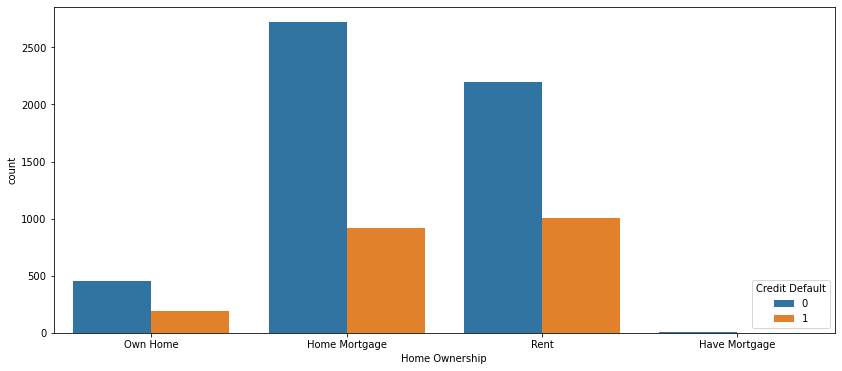

In [505]:
countplot_by_target(train_full, CURRENT_FEATURE)

In [506]:
check_feature_chi(train_full, CURRENT_FEATURE, 500)

Home Ownership: [Own Home, Home Mortgage] - 0.18911500849922896
Home Ownership: [Own Home, Rent] - 0.7842888405798815
Home Ownership: [Own Home, Have Mortgage] - 0.34745986221114566
Home Ownership: [Home Mortgage, Own Home] - 0.3808933024673564
Home Ownership: [Home Mortgage, Have Mortgage] - 0.403307001976971
Home Ownership: [Rent, Own Home] - 0.6592673827887483
Home Ownership: [Rent, Home Mortgage] - 0.21281549384753687
Home Ownership: [Have Mortgage, Own Home] - 0.5180536947971539


Объединим категории [Have Mortgage, Home Mortgage] 

In [507]:
train_full.loc[train_full["Home Ownership"] == 'Have Mortgage', "Home Ownership"] = 'Home Mortgage'

#### Признак "Years in current job" 

In [508]:
CURRENT_FEATURE = 'Years in current job'

Признак "Years in current job" обладает числовыми значениями, но в каждом значении присутствует слово "year(s)". Предлагается оставить только числовые значения. Строки со значениями "10+ years" и  "< 1 year" преобразовать в 10 и 0

Функция _replace_year_to_num_ преобразовывает категориальные значения признака "Years in current job" в числовые int:

In [509]:
def replace_year_to_num(df):
    df.replace({'Years in current job': {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2, 
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10      
}}, inplace=True)

Преобразование признака "Years in current job" в числовой:

In [510]:
replace_year_to_num(train_full)

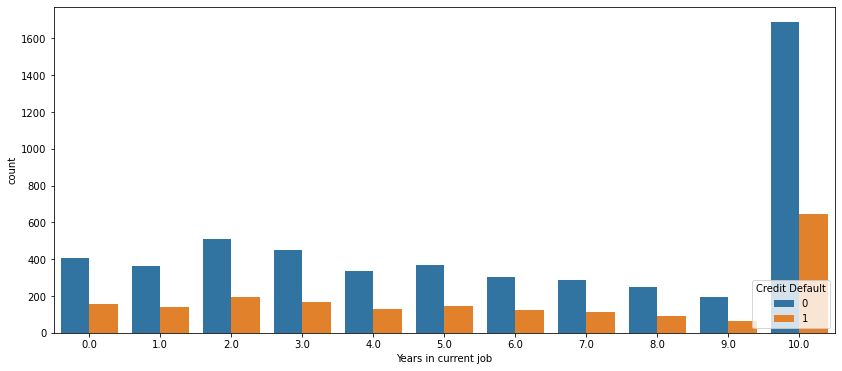

In [511]:
countplot_by_target(train_full, CURRENT_FEATURE)

#### Признак "Purpose" 

In [512]:
CURRENT_FEATURE = 'Purpose'

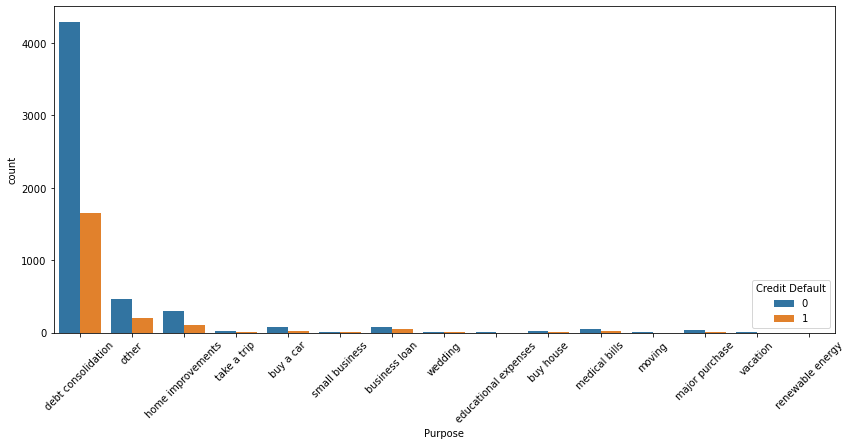

In [513]:
countplot_by_target(train_full, CURRENT_FEATURE, rotation=45)

Предлагается уменьшить количество категорий.
Заменим отдельные категории покупок, требующие большого количества средств (раз на них всзяли кредит), на 'major purchase'

In [514]:
train_full.loc[train_full['Purpose'] == 'buy a car', 'Purpose'] = 'major purchase'
train_full.loc[train_full['Purpose'] == 'buy house', 'Purpose'] = 'major purchase'
train_full.loc[train_full['Purpose'] == 'educational expenses', 'Purpose'] = 'major purchase'
train_full.loc[train_full['Purpose'] == 'medical bills', 'Purpose'] = 'major purchase'
train_full.loc[train_full['Purpose'] == 'moving', 'Purpose'] = 'major purchase'
train_full.loc[train_full['Purpose'] == 'renewable energy', 'Purpose'] = 'major purchase'
train_full.loc[train_full['Purpose'] == 'take a trip', 'Purpose'] = 'major purchase'
train_full.loc[train_full['Purpose'] == 'vacation', 'Purpose'] = 'major purchase'
train_full.loc[train_full['Purpose'] == 'wedding', 'Purpose'] = 'major purchase'

Заменим категорию 'small business' на 'business loan'

In [515]:
train_full.loc[train_full['Purpose'] == 'small business', 'Purpose'] = 'business loan'

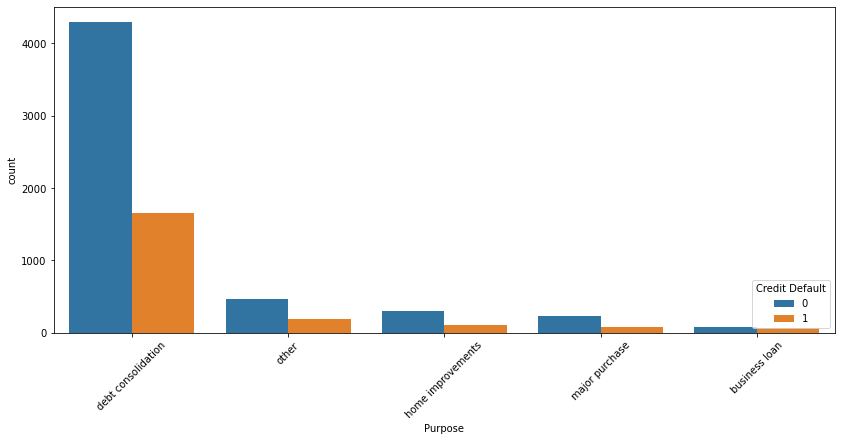

In [516]:
countplot_by_target(train_full, CURRENT_FEATURE, rotation=45)

In [517]:
# check_feature_chi(train_full, CURRENT_FEATURE, 1000)

#### Признак "Term" 

In [518]:
CURRENT_FEATURE = 'Term'

Преобразуем значения признака Term в 0 и 1:

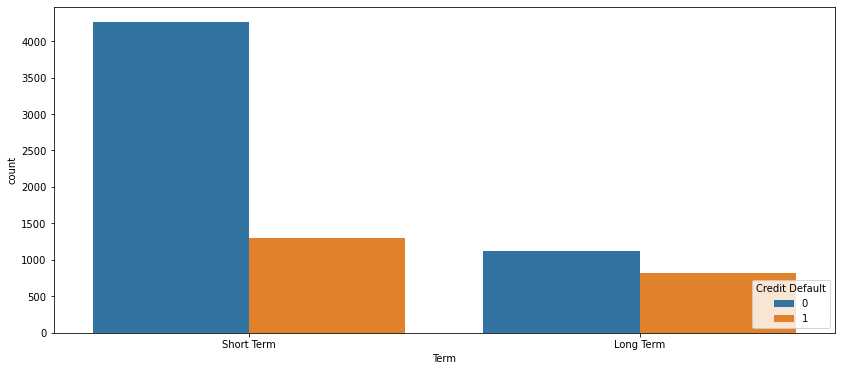

In [519]:
countplot_by_target(train_full, CURRENT_FEATURE)

In [520]:
train_full.replace({'Term': {'Short Term': 0, 'Long Term': 1}}, inplace=True)

In [521]:
train_full['Term'] = train_full['Term'].astype('int')

In [522]:
train_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id                            7500 non-null   int64  
 1   Home Ownership                7500 non-null   object 
 2   Annual Income                 5943 non-null   float64
 3   Years in current job          7129 non-null   float64
 4   Tax Liens                     7500 non-null   float64
 5   Number of Open Accounts       7500 non-null   float64
 6   Years of Credit History       7500 non-null   float64
 7   Maximum Open Credit           7500 non-null   float64
 8   Number of Credit Problems     7500 non-null   float64
 9   Months since last delinquent  3419 non-null   float64
 10  Bankruptcies                  7486 non-null   float64
 11  Purpose                       7500 non-null   object 
 12  Term                          7500 non-null   int64  
 13  Cur

## Обработка пропусков

### Признаки с пропусками

In [523]:
print(f"TRAIN:\n{train_pass_features}")

TRAIN:
{'Annual Income': 1557, 'Years in current job': 371, 'Months since last delinquent': 4081, 'Bankruptcies': 14, 'Credit Score': 1557}


#### Признак 'Annual Income' 
Данный признак имеет то же количество пропусков, что и 'Credit Score'.

In [524]:
for idx_1, idx_2 in zip(train_full['Annual Income'].isna(), train_full['Credit Score'].isna()):
    if idx_1 != idx_2:
        print('not OK')

Более того, индексы пропусков совпадают. Проверим корреляцию признаков.

### Анализ отоншения между признаками

In [525]:
def feature_corr_plot(feature):
    plt.figure(figsize=(8, 6))
    sns.barplot(x=train_full.corr().loc[feature].sort_values(ascending=False).values, 
                y=train_full.corr().loc[feature].sort_values(ascending=False).index)
    plt.title(f'Correlation with {feature}')

#### Признак 'Annual Income'

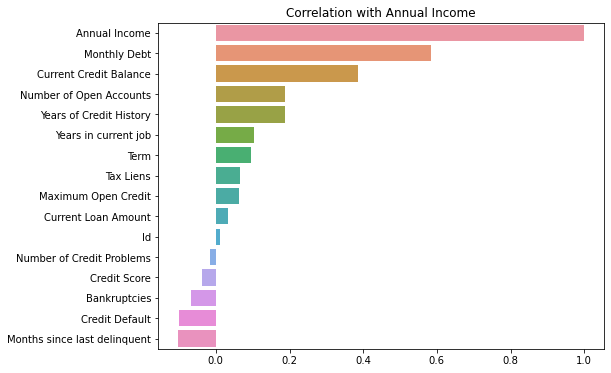

In [526]:
feature_corr_plot('Annual Income')

Самая высокая корреляция с признаками 'Monthly Debt' и 'Current Credit Balance'. Попробуем рассчитать недостающие значение 'Annual Income' следующим образом:
 - вычислим коэффициент, как отношение среднего 'Annual Income' к 'Monthly Debt'
 - вычислим 'Annual Income' как произведение коэффициента на значение 'Monthly Debt'

In [527]:
notnull_annual_income = train_full.loc[train_full['Annual Income'].notnull(), :]
coeff_1 = notnull_annual_income['Annual Income'].mean() / notnull_annual_income['Monthly Debt'].mean()
train_full['Annual Income'].fillna(train_full['Monthly Debt'] * coeff_1, inplace=True)

In [528]:
train_full['Annual Income'].count()

7500

#### Признак 'Months since last delinquent'
Данный имеет пропуски более чем 50%
1) попробуем удалить этот признак  
2) предположим, что пропуски - это отсутсвие просрочек, заменим пропуски нулями  
3) учтем признак 'Number of Credit Problems' 

In [529]:
# 1)

In [530]:
#train_full.drop(['Months since last delinquent'], axis=1, inplace=True)
#num_cols.remove('Months since last delinquent')

In [531]:
# 2)

In [532]:
train_full.loc[train_full['Months since last delinquent'].isna(), 'Months since last delinquent'] = 0

In [533]:
# 3)
#train_full.loc[train_full['Months since last delinquent'].isna(), ['Number of Credit Problems', 'Months since last delinquent']]

#### Признак 'Credit Score'

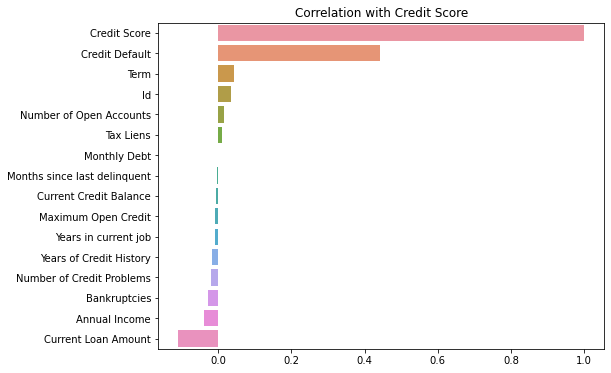

In [534]:
feature_corr_plot('Credit Score')

Самая высокая корреляция с целевым признаком 'Credit Default'.

In [535]:
print(train_full.loc[(train_full["Credit Score"] > 850 ), "Credit Score"].shape)

(400,)


Данный признак имеет много значений больше 850 (850 - максимальный кредитный рейтинг по всем найденным шкалам). Все такие значения больше 6000, скорее всего это выброс. Проверим эти значения:

In [536]:
train_full.loc[(train_full["Credit Score"] > 6000 ), "Credit Score"].head()

69     6470.0
87     7440.0
94     7010.0
96     7320.0
116    7390.0
Name: Credit Score, dtype: float64

Замечено, что многие значения оканчиваются на 0. Возможно он лишний, проверим все выбросные значения.
Функция _check_credit_score_outliers_ проверяет значения выбросов, б**о**льших 850. Предполагается, что в эти значения дописан лишний 0:

In [537]:
def check_credit_score_outliers(df):
    x = []
    for i in df.loc[(df["Credit Score"] > 850 ), "Credit Score"]:
        if i % 10 != 0:
            x.append(i)
    print(len(x))

In [538]:
check_credit_score_outliers(train_full)

0


 Таким образом, все выбросные значения оканчиваются на 0. Поделим все эти значения на 10:

In [539]:
train_full.loc[train_full['Credit Score'] > 850, 'Credit Score'] = train_full.loc[train_full['Credit Score'] > 850, 'Credit Score'] / 10

In [540]:
train_full.loc[(train_full["Credit Score"] > 850 ), "Credit Score"].count()

0

Заполним пропуски признака 'Credit Score' медианными значениями:

In [541]:
credit_score_median = train_full['Credit Score'].median()

In [542]:
train_full.loc[train_full['Credit Score'].isna(), 'Credit Score'] = credit_score_median

#### Признак 'Years in current job'

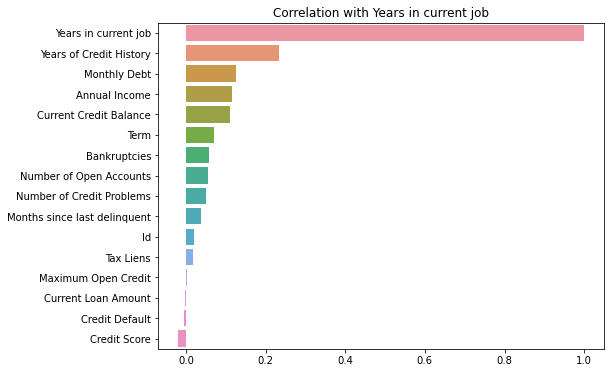

In [543]:
feature_corr_plot('Years in current job')

Самая высокая корреляция с признаком 'Years of Credit History', но не высокая.
Заполним пропуски признака 'Years in current job' медианными значениями:

In [544]:
years_in_current_job_median = train_full['Years in current job'].median()

In [545]:
train_full.loc[train_full['Years in current job'].isna(), 'Years in current job'] = years_in_current_job_median

#### Признак "Bankruptcies"

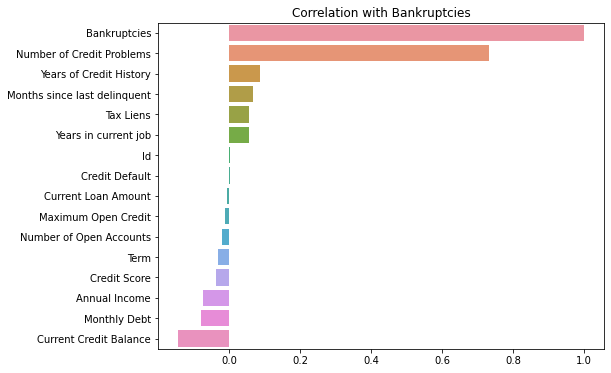

In [546]:
feature_corr_plot('Bankruptcies')

Высокая корреляция с признаком 'Number of Credit Problems'. Проверим значения признака 'Number of Credit Problems' при отсутствующих значениях признака 'Bankruptcies'

In [547]:
train_full.loc[train_full['Bankruptcies'].isnull() == True, ['Number of Credit Problems']].describe().T

,count,mean,std,min,25%,50%,75%,max
Number of Credit Problems,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Так как признак 'Number of Credit Problems' содержит только 0, заменим пропуски признака 'Bankruptcies' медианными значениями при 'Number of Credit Problems'=0 

In [548]:
bankruptcies_median = train_full.loc[train_full['Number of Credit Problems'] == 0, 'Bankruptcies'].median()

In [549]:
train_full.loc[train_full['Bankruptcies'].isna(), 'Bankruptcies'] = bankruptcies_median

Предположим, что признак "Bankruptcies" категориальный. Заменим все значения >1 на 1. Таким образом, 0 - отсутствие банкротств, 1 - наличие банкротств.

In [550]:
train_full.loc[train_full['Bankruptcies'] > 0, 'Bankruptcies'] = 1

In [551]:
# Все пропуски заполнены
train_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id                            7500 non-null   int64  
 1   Home Ownership                7500 non-null   object 
 2   Annual Income                 7500 non-null   float64
 3   Years in current job          7500 non-null   float64
 4   Tax Liens                     7500 non-null   float64
 5   Number of Open Accounts       7500 non-null   float64
 6   Years of Credit History       7500 non-null   float64
 7   Maximum Open Credit           7500 non-null   float64
 8   Number of Credit Problems     7500 non-null   float64
 9   Months since last delinquent  7500 non-null   float64
 10  Bankruptcies                  7500 non-null   float64
 11  Purpose                       7500 non-null   object 
 12  Term                          7500 non-null   int64  
 13  Cur

#### Признак 'Tax Liens'

In [552]:
train_full['Tax Liens'].unique()

array([0., 3., 1., 2., 4., 6., 5., 7.])

In [553]:
train_full[['Tax Liens']].describe().T

,count,mean,std,min,25%,50%,75%,max
Tax Liens,7500.0,0.030133,0.271604,0.0,0.0,0.0,0.0,7.0


Большинство значений признака равны 0, проверим количество значений больше 0:

In [554]:
train_full.loc[train_full['Tax Liens'] > 0, 'Tax Liens'].count()

134

Преобразуем признак 'Tax Liens' в категориальный: 0 - отсутствие обременений, 1 - наличие обременений.

In [555]:
train_full.loc[train_full['Tax Liens'] > 0, 'Tax Liens'] = 1

In [556]:
train_full['Tax Liens'].unique()

array([0., 1.])

#### Признак 'Number of Credit Problems'

In [557]:
train_full['Number of Credit Problems'].unique()

array([1., 0., 3., 2., 6., 4., 5., 7.])

In [558]:
train_full[['Number of Credit Problems']].describe().T

,count,mean,std,min,25%,50%,75%,max
Number of Credit Problems,7500.0,0.17,0.498598,0.0,0.0,0.0,0.0,7.0


Большинство значений признака равны 0, проверим количество значений больше 1:

In [559]:
train_full.loc[train_full['Number of Credit Problems'] > 1, 'Number of Credit Problems'].count()

149

Преобразуем признак 'Number of Credit Problems' в категориальный: 0 - отсутствие проблема с кредитами, 1 - наличие проблема.

In [560]:
train_full.loc[train_full['Number of Credit Problems'] > 0, 'Number of Credit Problems'] = 1

### Изменение типа признаков на int

Функция *f_features_to_int* преобразует признаки из списка features_to_int к типу int:

In [561]:
def f_features_to_int(df, df_name, features_to_int):
    print(f"\tПреобразование типа признаков для датасета \033[1m{df_name}\033[0m:")
    for feature in features_to_int:
        try:
            df[feature] = df[feature].astype(int)
            print(f"Значения признака \033[1m{feature}\033[0m преобразованы в int")
        except:
            print(f"Проблема с признаком {feature}:\n {i}")

In [562]:
# Заполненный тренировочный датасет
train_pass_features, train_features_to_int, train_features_binary, train_features_dummies = check_feature_values(train_full)

Id
	Unique values:
	[0 1 2 3 4] ... [7495 7496 7497 7498 7499]
	Feature not NaN size: 7500
	Type of values: int64
Пропусков нет
**************************************************
Home Ownership
	Unique values:
	['Own Home' 'Home Mortgage' 'Rent']
	Feature not NaN size: 7500
	Type of values: object
Пропусков нет
**************************************************
Annual Income
	Unique values:
	[ 482087. 1025487.  751412.  805068.  776264.] ... [1257610.          378999.82358018  402192.         2774697.32774148
  677340.71034715]
	Feature not NaN size: 7500
	Type of values: float64
Пропусков нет
**************************************************
Years in current job
	Unique values:
	[ 6. 10.  8.  7.  5.  1.  0.  4.  3.  2.  9.]
	Feature not NaN size: 7500
	Type of values: float64
Пропусков нет
Преобразовать в INT
**************************************************
Tax Liens
	Unique values:
	[0. 1.]
	Feature not NaN size: 7500
	Type of values: float64
Пропусков нет
Преобразовать в INT
****

In [563]:
f_features_to_int(train_full, 'train_full', train_features_to_int)

	Преобразование типа признаков для датасета train_full:
Значения признака Years in current job преобразованы в int
Значения признака Tax Liens преобразованы в int
Значения признака Number of Open Accounts преобразованы в int
Значения признака Maximum Open Credit преобразованы в int
Значения признака Number of Credit Problems преобразованы в int
Значения признака Months since last delinquent преобразованы в int
Значения признака Bankruptcies преобразованы в int
Значения признака Current Loan Amount преобразованы в int
Значения признака Current Credit Balance преобразованы в int
Значения признака Monthly Debt преобразованы в int
Значения признака Credit Score преобразованы в int


In [564]:
train_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id                            7500 non-null   int64  
 1   Home Ownership                7500 non-null   object 
 2   Annual Income                 7500 non-null   float64
 3   Years in current job          7500 non-null   int64  
 4   Tax Liens                     7500 non-null   int64  
 5   Number of Open Accounts       7500 non-null   int64  
 6   Years of Credit History       7500 non-null   float64
 7   Maximum Open Credit           7500 non-null   int64  
 8   Number of Credit Problems     7500 non-null   int64  
 9   Months since last delinquent  7500 non-null   int64  
 10  Bankruptcies                  7500 non-null   int64  
 11  Purpose                       7500 non-null   object 
 12  Term                          7500 non-null   int64  
 13  Cur

### Проверка выбросов

**Функция _plot_outliers_ распечатывает 1 график для каждого признака:**
 - Ящик с усами (BoxPlot)

In [565]:
def plot_outliers(df, col_n):
# def plot_outliers(df_tr, df_te, col_n):
#     fig, ax = plt.subplots(1, 2, figsize=(16,5))
#     ax[0].set_title(f'KDE for both datasets on {col_n}')
#     plt.set_title('Train Dataset')
#     ax[2].set_title('Test Dataset')
#     df_tr[col_n].plot.kde(color='#628cbf', ax=ax[0])
#     df_te[col_n].plot.kde(color='#c95556', ax=ax[0])
    sns.boxplot(data=df, x=col_n, color='#628cbf')
#     sns.boxplot(data=df_te, x=col_name, color='#c95556', ax=ax[2])
    plt.show()

In [566]:
num_cols = [
    'Annual Income',
    'Years in current job',
    'Tax Liens',
    'Number of Open Accounts',
    'Years of Credit History',
    'Maximum Open Credit',
    'Number of Credit Problems',
    'Months since last delinquent',
    'Bankruptcies',
    'Term',
    'Current Loan Amount',
    'Current Credit Balance',
    'Monthly Debt',
    'Credit Score']

cat_cols =[
    'Home Ownership',
    'Purpose'
]

TARGET = ['Credit Default']

# for col_name in num_cols:
#     plot_outliers(train_full, col_name)
    
#     plot_outliers(train_full, test_full, col_name)

#### Выводы из визуального анализа:
* Возможно есть выбросы сверху, особо заметные из них:
    * В признаке **'Current Loan Amount'** есть много одинаковых больших значений  
    
Рассмотрим каждый из пунктов по отдельности

### Обработка выбросов<a class="anchor" id="outliers"></a>

#### Признак 'Current Loan Amount'

In [567]:
train_full.loc[(train_full["Current Loan Amount"] == 99999999), ['Credit Score', 'Credit Default']].describe().T

,count,mean,std,min,25%,50%,75%,max
Credit Score,870.0,730.225287,21.39523,601.0,726.0,737.0,744.0,751.0
Credit Default,870.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0


Заметим, что при всех выбросных значениях "Current Loan Amount"=99999999, значение целевого признака 'Credit Default'=0. Создадим новый признак "Current Loan Amount_Credit Default"

In [568]:
train_full['Current Loan Amount_Credit Default'] = 1
train_full.loc[train_full['Current Loan Amount_Credit Default'] == 99999999, 'Current Loan Amount_Credit Default'] = 0

In [569]:
num_cols.append('Current Loan Amount_Credit Default')

In [570]:
print(train_full.loc[(train_full["Current Loan Amount"] == 99999999), :].shape)

(870, 19)


Само значение 99999999 скорее всего является выбросом (ближайшее значение меньше 800000). Заменим эти значения медианными

In [571]:
train_full.loc[train_full['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = train_full['Current Loan Amount'].median()

Проверим результат замены:

In [572]:
print(train_full.loc[(train_full["Current Loan Amount"] == 99999999), :].shape)

(0, 19)


#### Остальные признаки

In [573]:
from collections import Counter
def check_outliers(df, n, features):
    outlier_idxs = [] 
    for col in features:
        # 25%
        q1 = np.percentile(df[col], 25)
        # 75%
        q3 = np.percentile(df[col], 75)
        # IQR
        outlier_step = 1.5 * (q3 - q1)
        
        # Определение индексов с отклонениями
        outlier_list_col = df[(df[col] < q1 - outlier_step) | (df[col] > q3 + outlier_step )].index
        
        # Добавить найденные индексы в общий список
        outlier_idxs.extend(outlier_list_col)
        
    # Выбрать наблюдения, содержащие более n отклонений
    outlier_idxs = Counter(outlier_idxs)        
    multiple_outliers = [k for k, v in outlier_idxs.items() if v > n]
    
    return multiple_outliers

In [574]:
outliers_to_drop = check_outliers(train_full, 2, num_cols)

In [575]:
len(outliers_to_drop)

499

#### Удаление выбросных строк:

In [576]:
# train_full = train_full.drop(outliers_to_drop, axis=0).reset_index(drop=True)

In [577]:
train_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 19 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Id                                  7500 non-null   int64  
 1   Home Ownership                      7500 non-null   object 
 2   Annual Income                       7500 non-null   float64
 3   Years in current job                7500 non-null   int64  
 4   Tax Liens                           7500 non-null   int64  
 5   Number of Open Accounts             7500 non-null   int64  
 6   Years of Credit History             7500 non-null   float64
 7   Maximum Open Credit                 7500 non-null   int64  
 8   Number of Credit Problems           7500 non-null   int64  
 9   Months since last delinquent        7500 non-null   int64  
 10  Bankruptcies                        7500 non-null   int64  
 11  Purpose                             7500 no

Проверка пропусков после их удаления в обоих датасетах:

In [578]:
print(f'Число пропусков в TRAIN:\n{train_full.isna().sum().sum()}')

Число пропусков в TRAIN:
0


### Преобразование категориальных признаков в dummies

In [579]:
cat_cols

['Home Ownership', 'Purpose']

#### Преобразование значений категориальных признаков, имеющих более 2 значений, в dummies переменные

In [580]:
def cat_to_dummies(df):
#     print(df)
    for feature in df.select_dtypes(include='object').columns:
        df = pd.concat([df, pd.get_dummies(df[feature], prefix=feature)], axis=1)
        print(f"Значения признака \033[1m{feature}\033[0m преобразованы в DUMMIES")
    return df

### Удаление лишних признаков

In [581]:
train_full_dum = cat_to_dummies(train_full)

Значения признака Home Ownership преобразованы в DUMMIES
Значения признака Purpose преобразованы в DUMMIES


In [582]:
TRAIN_FEATURES_NAMES = train_full.columns
TRAIN_FEATURES_NAMES_DUM = train_full_dum.columns
# features_to_delete = ['Id', TARGET_NAME] + cat_cols
TRAIN_FEATURES_NAMES_DUM = TRAIN_FEATURES_NAMES_DUM.drop(['Id', TARGET_NAME] + cat_cols)
TRAIN_FEATURES_NAMES = TRAIN_FEATURES_NAMES.drop(['Id', TARGET_NAME])

In [583]:
train_full_dum = train_full_dum.drop(columns=cat_cols)

### Матрица корреляций

In [584]:
def correl_matrix(df):
    plt.figure(figsize = (25, 20))

    sns.set(font_scale=0.8)
    sns.heatmap(df[:].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

    plt.title('Матрица корреляции всех признаков')
    plt.show()

In [585]:
# correl_matrix(train_full)

## Подбор гиперпараметров

In [586]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score
from imblearn.over_sampling import SMOTE
import itertools
from imblearn.pipeline import Pipeline as SM_Pipeline
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import MinMaxScaler

### Нормализация данных<a class="anchor" id="normalization"></a>

In [587]:
def norm_stand_scal(df, num_features):
    scaler = StandardScaler()
#     df_norm = df.copy()
    df[num_features] = scaler.fit_transform(df[num_features])
    return df

### Разделение датасетов для обучения

In [588]:
def train_test_dev(df, features, target):
    X = df[features]
    y = df[target]
    return train_test_split(X, y, shuffle=True, test_size=0.25)

### Балансировка целевого признака<a class="anchor" id="target_balancing"></a>

Функция _balance_df_by_target_ проводит балансировку

In [589]:
def balance_df_by_target(df, target_name):
    target_counts = df[target_name].value_counts()
#     print(target_counts)

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [590]:
def balancing(bal_x, bal_y):
    df_for_balancing = pd.concat([bal_x, bal_y], axis=1)
    df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    print(df_balanced[TARGET_NAME].value_counts())
    return df_balanced.drop(columns=TARGET_NAME), df_balanced[TARGET_NAME]

#  Создание и обучение модели

Функция _get_classification_report_ выдает отчет _classification_report_

In [591]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

## CatBoost (cat_features=cat_cols)

In [592]:
train_full_norm = norm_stand_scal(train_full, num_cols)

In [593]:
X_train, X_test, y_train, y_test = train_test_dev(train_full_norm, TRAIN_FEATURES_NAMES, TARGET_NAME)

In [594]:
X_train, y_train = balancing(X_train, y_train)

0    4053
1    3144
Name: Credit Default, dtype: int64


In [595]:
X_train[cat_cols] = X_train[cat_cols].astype(str)
X_test[cat_cols] = X_test[cat_cols].astype(str)

In [596]:
model_catb = catb.CatBoostClassifier(
    silent=True, 
    cat_features=cat_cols
)
model_catb.fit(X_train, y_train)
y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.91      0.90      4053
           1       0.88      0.84      0.86      3144

    accuracy                           0.88      7197
   macro avg       0.88      0.88      0.88      7197
weighted avg       0.88      0.88      0.88      7197

TEST

              precision    recall  f1-score   support

           0       0.78      0.78      0.78      1334
           1       0.46      0.46      0.46       541

    accuracy                           0.69      1875
   macro avg       0.62      0.62      0.62      1875
weighted avg       0.69      0.69      0.69      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1038  296
1                292  249


#### Подбор гиперпараметров

In [597]:
model_catb_1 = catb.CatBoostClassifier(
    silent=True, 
    cat_features=cat_cols
)

In [598]:
params = {'n_estimators':[50, 65, 80, 100], 
          'max_depth':[5, 7, 10],
          'learning_rate':[0.001, 0.01, 0.05, 0.1]}

In [599]:
cv=KFold(n_splits=3, shuffle=True)

In [600]:
rs = RandomizedSearchCV(model_catb_1, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x7fe99cc98290>,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.05,
                                                          0.1],
                                        'max_depth': [5, 7, 10],
                                        'n_estimators': [50, 65, 80, 100]},
                   scoring='f1')

In [601]:
rs.best_params_

{'n_estimators': 65, 'max_depth': 10, 'learning_rate': 0.1}

In [602]:
rs.best_score_

0.6163898092444281

### Обучение и оценка модели

In [603]:
final_model = catb.CatBoostClassifier(
    n_estimators=rs.best_params_['n_estimators'], 
    max_depth=rs.best_params_['max_depth'], 
    learning_rate=rs.best_params_['learning_rate'], 
    cat_features=cat_cols,
    silent=True)

final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.80      0.87      0.84      4053
           1       0.82      0.72      0.77      3144

    accuracy                           0.81      7197
   macro avg       0.81      0.80      0.80      7197
weighted avg       0.81      0.81      0.81      7197

TEST

              precision    recall  f1-score   support

           0       0.78      0.79      0.78      1334
           1       0.46      0.45      0.45       541

    accuracy                           0.69      1875
   macro avg       0.62      0.62      0.62      1875
weighted avg       0.69      0.69      0.69      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1048  286
1                300  241


## CatBoost (dummies)

In [604]:
train_full_norm_dum = norm_stand_scal(train_full_dum, num_cols)
# train_full_norm_dum = norm_stand_scal(train_full_dum, TRAIN_FEATURES_NAMES_DUM)

In [605]:
X_train, X_test, y_train, y_test = train_test_dev(train_full_norm_dum, TRAIN_FEATURES_NAMES_DUM, TARGET_NAME)

In [606]:
X_train, y_train = balancing(X_train, y_train)

0    4041
1    3168
Name: Credit Default, dtype: int64


In [607]:
# X_train[cat_cols] = X_train[cat_cols].astype(str)
# X_test[cat_cols] = X_test[cat_cols].astype(str)

In [608]:
model_catb_dum = catb.CatBoostClassifier(
    silent=True
)
calib = CalibratedClassifierCV(base_estimator=model_catb_dum, method='sigmoid', cv=2)

model_catb_dum.fit(X_train, y_train)
calib.fit(X_train, y_train)

y_train_pred = model_catb_dum.predict(X_train)
y_test_pred = model_catb_dum.predict(X_test)
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      4041
           1       0.89      0.87      0.88      3168

    accuracy                           0.90      7209
   macro avg       0.90      0.89      0.89      7209
weighted avg       0.90      0.90      0.90      7209

TEST

              precision    recall  f1-score   support

           0       0.78      0.77      0.78      1346
           1       0.44      0.45      0.44       529

    accuracy                           0.68      1875
   macro avg       0.61      0.61      0.61      1875
weighted avg       0.69      0.68      0.68      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1042  304
1                291  238


#### Подбор гиперпараметров

In [611]:
params = {'n_estimators':[50, 75, 100, 150], 
          'max_depth':[5, 7, 10],
          'learning_rate':[0.001, 0.01, 0.05, 0.1]}

In [612]:
cv=KFold(n_splits=5, shuffle=True)

In [613]:
rs = RandomizedSearchCV(model_catb_dum, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x7fe99cc1afd0>,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.05,
                                                          0.1],
                                        'max_depth': [5, 7, 10],
                                        'n_estimators': [50, 75, 100, 150]},
                   scoring='f1')

In [614]:
rs.best_params_

{'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1}

In [615]:
rs.best_score_

0.7824195014604944

### Обучение и оценка модели

In [620]:
final_model = catb.CatBoostClassifier(
    n_estimators=50, 
    max_depth=7, 
    learning_rate=0.1, 
#     n_estimators=rs.best_params_['n_estimators'], 
#     max_depth=rs.best_params_['max_depth'], 
#     learning_rate=rs.best_params_['learning_rate'], 
    silent=True)

calib = CalibratedClassifierCV(base_estimator=final_model, method='sigmoid', cv=3)
final_model.fit(X_train, y_train)

calib.fit(X_train, y_train)
# print(final_model.predict_proba(X_train))
# print(calib.predict_proba(X_train))

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.77      0.84      0.80      4041
           1       0.77      0.67      0.72      3168

    accuracy                           0.77      7209
   macro avg       0.77      0.76      0.76      7209
weighted avg       0.77      0.77      0.76      7209

TEST

              precision    recall  f1-score   support

           0       0.78      0.76      0.77      1346
           1       0.43      0.46      0.44       529

    accuracy                           0.68      1875
   macro avg       0.61      0.61      0.61      1875
weighted avg       0.68      0.68      0.68      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1028  318
1                287  242


### Выбор наиболее важных признаков

In [343]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (10, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [350]:
def get_top_important_features(x_tr, model, num):
    return show_feature_importances(x_tr.columns, model.feature_importances_, num)

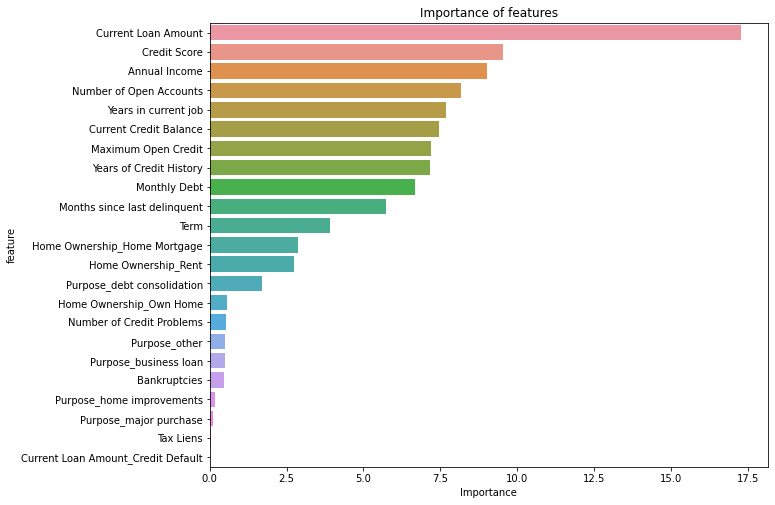

In [351]:
important_features_top = get_top_important_features(X_train, final_model_dum, 15)

In [352]:
# important_features_top

In [353]:
# final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=7, l2_leaf_reg=10, silent=True, random_state=123)
# final_model = catb.CatBoostClassifier(
#     n_estimators=500, 
#     max_depth=7, 
#     learning_rate=0.05, 
#     cat_features=cat_cols,
#     silent=True)
final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])
y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])


get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3791
           1       1.00      1.00      1.00      2918

    accuracy                           1.00      6709
   macro avg       1.00      1.00      1.00      6709
weighted avg       1.00      1.00      1.00      6709

TEST

              precision    recall  f1-score   support

           0       0.75      0.87      0.81      1235
           1       0.50      0.32      0.39       516

    accuracy                           0.71      1751
   macro avg       0.63      0.59      0.60      1751
weighted avg       0.68      0.71      0.68      1751

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1072  163
1                353  163


## Предсказания тестовых данных¶

In [ ]:
test_full = pd.read_csv(TEST_DATASET_PATH)

In [ ]:
test_full.shape

In [ ]:
# Тестовый датасет
test_pass_features, test_features_to_int, test_features_binary, test_features_dummies = check_feature_values(test_full)

### Изменение типа признаков на int

In [ ]:
f_features_to_int(test_full, 'test_full', test_features_to_int)

Преобразование признака "Years in current job" для тестового датасета:

In [ ]:
replace_year_to_num(test_full)

In [ ]:
test_full.loc[test_full['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = test_full['Current Loan Amount'].median()

In [ ]:
test_full.loc[test_full['Credit Score'] > 850, 'Credit Score'] = test_full.loc[test_full['Credit Score'] > 850, 'Credit Score'] / 10

In [ ]:
print(f"TEST:\n{test_pass_features}")

In [ ]:
# Медианы
annual_income_median = test_full['Annual Income'].median()
credit_score_median = test_full['Credit Score'].median()
years_in_current_job_median = test_full['Years in current job'].median()

In [ ]:
test_full.loc[test_full['Annual Income'].isna(), 'Annual Income'] = annual_income_median
test_full.loc[test_full['Credit Score'].isna(), 'Credit Score'] = credit_score_median
test_full.loc[test_full['Years in current job'].isna(), 'Years in current job'] = years_in_current_job_median
test_full['Bankruptcies'].fillna(test_full['Bankruptcies'].mode().iloc[0], inplace=True)

In [ ]:
test_full["Bankruptcies"] = test_full["Bankruptcies"].astype(object)

In [ ]:
# test_full.drop(['Months since last delinquent'], axis=1, inplace=True)
test_full.loc[test_full['Months since last delinquent'].isna(), 'Months since last delinquent'] = 0

In [ ]:
print(f'Число пропусков в TEST:\n{test_full.isna().sum().sum()}')

In [ ]:
test_full.replace({'Term': {'Short Term': 0, 'Long Term': 1}}, inplace=True)

In [ ]:
test_full = cat_to_dummies(test_full)

In [ ]:
test_full.drop(['Home Ownership', 'Bankruptcies', 'Purpose'], axis=1, inplace=True)

In [ ]:
test_full = norm_stand_scal(test_full, num_cols)

In [ ]:
# test_full[cat_cols] = test_full[cat_cols].astype(str)

In [ ]:
# test_full = test_full[TRAIN_FEATURES_NAMES]
# test_full.info()

In [ ]:
# Проводим предсказание на тестовых данных
TEST_FEATURES_NAMES_DUM = TRAIN_FEATURES_NAMES_DUM.drop('Purpose_renewable energy')
pred_test = final_model.predict(test_full[TEST_FEATURES_NAMES_DUM])

In [ ]:
test_full[TARGET_NAME] = pred_test
test_full[TARGET_NAME] = test_full[TARGET_NAME].astype('int')

In [ ]:
# Сохраняем полученные предсказания
# test_full.loc[:, ['Id', TARGET_NAME]].to_csv('./kaggle/damkkh_predictions_20201027_0827.csv', index=None)
test_full[['Id', TARGET_NAME]].to_csv('./kaggle/damkkh_predictions_20201028_0746.csv', index=False)